
<h3>Title = Prediction of student performance from gameplay using neural network</h3>
<h3>kaggle competitions download -c predict-student-performance-from-game-play</h3>






# Importing the necessary libraries

In [1]:
import numpy as np 
import pandas as pd  
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense , Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

column_types = {
    'event_name': 'category',
    'elapsed_time': np.int32,
    'name': 'category',
    'level': np.uint8,
    'room_coor_y': np.float32,
    'room_coor_x': np.float32,
    'screen_coor_y': np.float32,
    'screen_coor_x': np.float32,
    'hover_duration': np.float32,
    'text': 'category',
    'room_fqid': 'category',
    'fqid': 'category',
    'text_fqid': 'category',
    'hq': 'category',
    'fullscreen': 'category',
    'music': 'category',
    'level_group': 'category'
}
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=column_types)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Our dataset it too large, the first train data has 26296946 entires and  20 columns so we tried to decrease the volume of the data. So We can potentially decreased the memory usage of these columns by converting numerical columns to smaller data types, such as int8, int32, float32,

In [2]:
print(train.dtypes)


session_id           int64
index                int64
elapsed_time         int32
event_name        category
name              category
level                uint8
page               float64
room_coor_x        float32
room_coor_y        float32
screen_coor_x      float32
screen_coor_y      float32
hover_duration     float32
text              category
fqid              category
room_fqid         category
text_fqid         category
fullscreen        category
hq                category
music             category
level_group       category
dtype: object


In [3]:
print(train.head(1))
print(train.shape)

          session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991394  -159.314682          380.0          494.0             NaN   

        text   fqid                       room_fqid  \
0  undefined  intro  tunic.historicalsociety.closet   

                              text_fqid fullscreen hq music level_group  
0  tunic.historicalsociety.closet.intro          0  0     1         0-4  
(26296946, 20)


# missing values visualization 

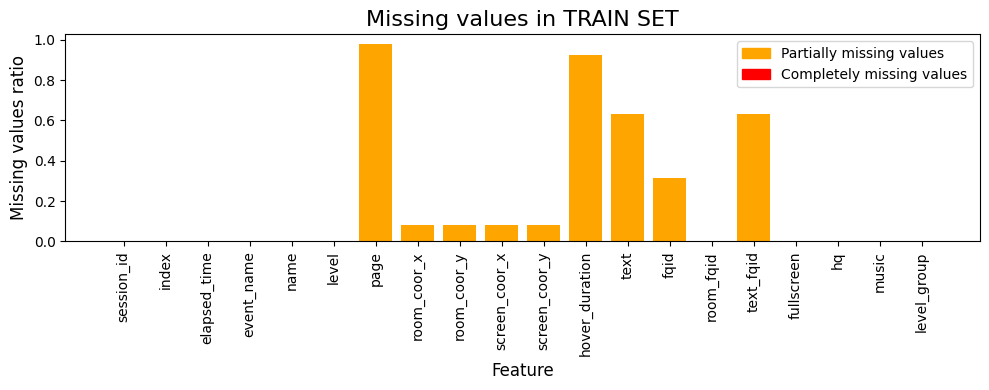

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

train_missing_ratios = train.isna().sum() / len(train)

plt.figure(figsize=(10, 4))

plt.bar(train_missing_ratios.index,
        train_missing_ratios.values,
        color=['red' if ratio == 1 else 'orange' for ratio in train_missing_ratios.values])
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Missing values ratio', fontsize=12)
plt.title('Missing values in TRAIN SET', fontsize=16)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partially missing values', 'Completely missing values'])
plt.tight_layout()
plt.show()

some of the variables like hq, music, fullscrren doesnot play any role in predection so we will be removing them from ourdataset

In [6]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
print(targets.head())

             session_id  correct
0  20090312431273200_q1        1
1  20090312433251036_q1        0
2  20090312455206810_q1        1
3  20090313091715820_q1        0
4  20090313571836404_q1        1


Our dataset has session_id in common but both of the session_id are  diff, train dataframe session id does not have "q" but train_level session_id has "q" so we are  extracting the session and question numbers("q") from the 'session_id' column.

In [7]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets['session_id'].apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets['session_id'].apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


We will focus on the values of the "Correct" column for each question, we will see visual representation of the data to help analyze the distribution of correct and incorrect responses for each question.The no of question("q") in session_id is the one of the important variabe in our project so we are tring to visualaize them. 

Due to large volume of data it was taking more space of gpu of kaggle and also taking alot of time to give the result, so I did not visualize others 

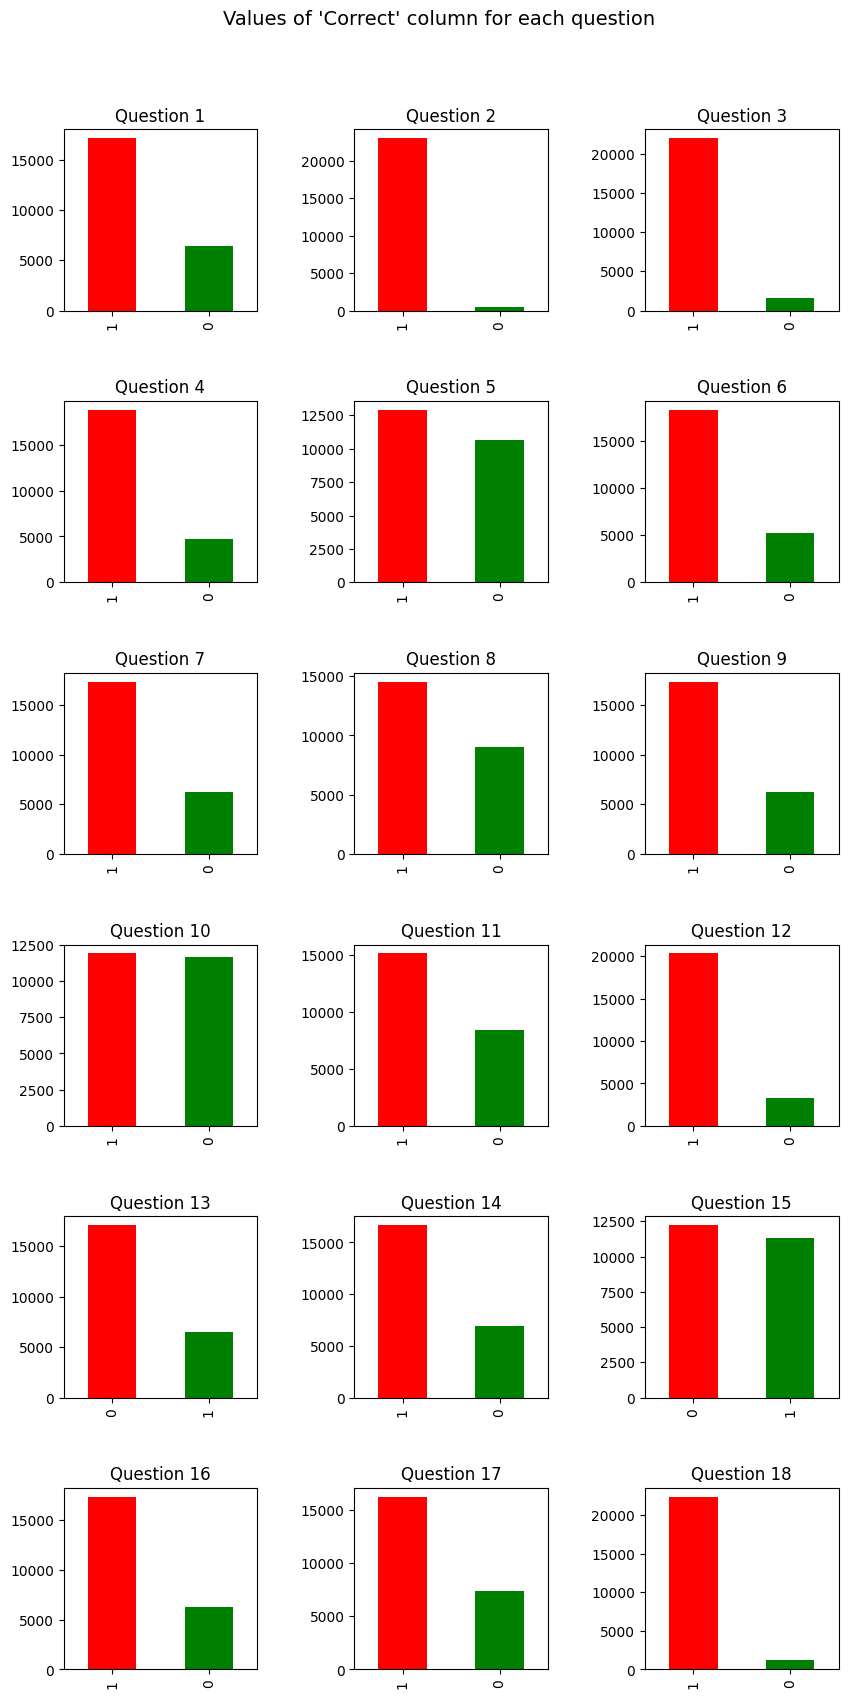

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Values of 'Correct' column for each question", fontsize=14, y=0.94)

for q_num in range(1, 19):
    ax = plt.subplot(6, 3, q_num)
    temp_df = targets.loc[targets.q == q_num]
    temp_df = temp_df.correct.value_counts()
    temp_df.plot(ax=ax, kind="bar", color=['red', 'green'])

    # Format the chart
    ax.set_title("Question " + str(q_num))
    ax.set_xlabel("")

In [11]:
def reduce_memory_usage(df):
    print(f'Memory usage of dataframe is {df.memory_usage().sum() / 1024**2:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if col_type not in ['datetime64[ns]', 'category', 'object']:
            c_min, c_max = df[col].min(), df[col].max()

            if 'int' in col_type:
                for np_type in [np.int8, np.int16, np.int32, np.int64]:
                    if np.iinfo(np_type).min < c_min and np.iinfo(np_type).max > c_max:
                        df[col] = df[col].astype(np_type)
                        break
            else:
                for np_type in [np.float16, np.float32]:
                    if np.finfo(np_type).min < c_min and np.finfo(np_type).max > c_max:
                        df[col] = df[col].astype(np_type)
                        break
        elif col_type == 'object':
            df[col] = df[col].astype('category')

    print(f"Memory usage became: {df.memory_usage().sum() / 1024**2} MB")
    return df

In [41]:
#Reduce Memory Usage
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [12]:
def feature_engineer(train):
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [40]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 400)

def reduce_memory_usage(train):
    return train
print(train.head(2))


          session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   
1  20090312431273200      1          1323    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991394  -159.314682          380.0          494.0             NaN   
1  -413.991394  -159.314682          380.0          494.0             NaN   

                            text    fqid                       room_fqid  \
0                      undefined   intro  tunic.historicalsociety.closet   
1  Whatcha doing over there, Jo?  gramps  tunic.historicalsociety.closet   

                                           text_fqid fullscreen hq music  \
0               tunic.historicalsociety.closet.intro          0  0     1   
1  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   

  level_group  
0         0-4  
1         0-4  


In [43]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

df = feature_engineer(train)
print( df.shape )


(70686, 22)


In [44]:
print(df.columns)

Index(['level_group', 'event_name_nunique', 'name_nunique', 'fqid_nunique',
       'room_fqid_nunique', 'text_fqid_nunique', 'elapsed_time', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'elapsed_time_std', 'level_std', 'page_std',
       'room_coor_x_std', 'room_coor_y_std', 'screen_coor_x_std',
       'screen_coor_y_std', 'hover_duration_std'],
      dtype='object')


In [45]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('train with', len(ALL_USERS) ,'users info')

train with 21 features
train with 23562 users info


We used to group-based K-fold cross-validation, while also setting up a DataFrame for out-of-fold (OOF) predictions filled with zeros.

In [49]:
gkf = GroupKFold(n_splits=5)
oof_table = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)

In [50]:
oof_table = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index=ALL_USERS)
nn_models = {}

for idx, (train_idx, val_idx) in enumerate(gkf.split(X=df, groups=df.index)):
    print(f"{'*' * 25}\n*** Fold {idx + 1}\n{'*' * 25}")
    
    for question in range(1, 19):
        print(f"{question}, ", end="")
        group = '0-4' if question <= 3 else ('5-12' if question <= 13 else '13-22')
        
        training_data = df.iloc[train_idx].loc[df.iloc[train_idx].level_group == group]
        training_users = training_data.index.values
        training_targets = targets.loc[targets.q == question].set_index('session').loc[training_users]
        training_targets['incorrect'] = (1 - training_targets['correct']).abs()
        
        validation_data = df.iloc[val_idx].loc[df.iloc[val_idx].level_group == group]
        validation_users = validation_data.index.values
        validation_targets = targets.loc[targets.q == question].set_index('session').loc[validation_users]
        
        keras.backend.clear_session()
        nn = keras.models.Sequential([
        keras.layers.Dense(64, activation="elu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation="elu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(16, activation="elu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(8, activation="elu"),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(1, activation="sigmoid")
        ])

        nn.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=0.05), metrics=['accuracy'])
        train_history = nn.fit(training_data[FEATURES].astype('float32'), training_targets['correct'], epochs=10, verbose=0)
        
        nn_models[f'{group}_{question}'] = nn
        nn_predictions = nn.predict(validation_data[FEATURES].astype('float32'))
        combined_arr = np.hstack((np.zeros(nn_predictions.shape), nn_predictions))
        oof_table.loc[validation_users, question - 1] = combined_arr[:, 1]
    print()

*************************
*** Fold 1
*************************
148/148 [==============================] - 0s 2ms/step

*************************
*** Fold 2
*************************
148/148 [==============================] - 0s 2ms/step

*************************
*** Fold 3
*************************
148/148 [==============================] - 0s 2ms/step

*************************
*** Fold 4
*************************
148/148 [==============================] - 0s 2ms/step

*************************
*** Fold 5
*************************
148/148 [==============================] - 0s 2ms/step



In [53]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

true = oof_table.copy()

for k in range(18):
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

# find the best threshold to convert probabilities into 1s and 0s
scores = []
thresholds = []
best_score = 0
best_threshold = 0

for threshold in np.arange(0.4, 0.81, 0.01):
    preds = (oof_table.values.reshape((-1)) > threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_score:
        best_score = m
        best_threshold = threshold

# compute evaluation metrics per question and overall
print('\n=== Evaluation Metrics ===')
print(f'{"Question":<8} {"Precision":<12} {"Recall":<12} {"F1 Score":<12} {"Accuracy":<12}')

for k in range(18):
    preds = (oof_table[k].values > best_threshold).astype('int')
    p = precision_score(true[k].values, preds, average='macro')
    r = recall_score(true[k].values, preds, average='macro')
    f1 = f1_score(true[k].values, preds, average='macro')
    acc = accuracy_score(true[k].values, preds)
    print(f'Q{k:<8} {p:.4f}       {r:.4f}       {f1:.4f}       {acc:.4f}')

overall_preds = (oof_table.values.reshape((-1)) > best_threshold).astype('int')
overall_p = precision_score(true.values.reshape((-1)), overall_preds, average='macro')
overall_r = recall_score(true.values.reshape((-1)), overall_preds, average='macro')
overall_f1 = f1_score(true.values.reshape((-1)), overall_preds, average='macro')
overall_acc = accuracy_score(true.values.reshape((-1)), overall_preds)

print(f'==> Overall Precision = {overall_p:.4f}, Recall = {overall_r:.4f}, F1 = {overall_f1:.4f}, Accuracy = {overall_acc:.4f}')


=== Evaluation Metrics ===
Question Precision    Recall       F1 Score     Accuracy    
Q0        0.3637       0.5000       0.4211       0.7275
Q1        0.4894       0.5000       0.4946       0.9788
Q2        0.4670       0.5000       0.4829       0.9340
Q3        0.3991       0.5000       0.4439       0.7982
Q4        0.2259       0.5000       0.3112       0.4517
Q5        0.3880       0.5000       0.4369       0.7760
Q6        0.3680       0.5000       0.4240       0.7361
Q7        0.4986       0.4985       0.4984       0.5221
Q8        0.3681       0.5000       0.4241       0.7363


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Q9        0.2473       0.5000       0.3309       0.4946
Q10       0.5045       0.5047       0.4746       0.4756
Q11       0.4315       0.5000       0.4632       0.8630
Q12       0.3624       0.5000       0.4203       0.7249
Q13       0.3538       0.5000       0.4144       0.7077
Q14       0.2595       0.5000       0.3417       0.5190
Q15       0.3674       0.5000       0.4236       0.7349
Q16       0.4970       0.4978       0.4893       0.6108
Q17       0.4753       0.5000       0.4873       0.9506


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

==> Overall Precision = 0.6473, Recall = 0.6457, F1 = 0.6465, Accuracy = 0.7079


# Changing the model architecture

# first neural network model 
we used  "elu" activation function for all hidden layers, except for the output layer which uses the sigmoid activation function and alsoit has 4 dense layers with 64, 32, 16, and 8 units respectively but we tried to change the model achetechture in second model.
# second model
Second model with 6 dense layers  and will be using  the "linear" activation function for all hidden layers, along with a LeakyReLU activation function with an alpha value of 0.1 for all layers, except the output layer 
Additionaly,  first model trains with fewer epochs (10) and a smaller batch size (32) than the second model, which uses a larger number of epochs (20) and batch size (32) during training

In [54]:
import numpy as np
import pandas as pd
import keras
from keras.layers import LeakyReLU
from sklearn.model_selection import GroupKFold

oof_table = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index=ALL_USERS)
nn_models = {}
gkf = GroupKFold(n_splits=5)

for idx, (train_idx, val_idx) in enumerate(gkf.split(X=df, groups=df.index)):
    print(f"{'*' * 25}\n*** Fold {idx + 1}\n{'*' * 25}")
    
    for question in range(1, 19):
        print(f"{question}, ", end="")
        group = '0-4' if question <= 3 else ('5-12' if question <= 13 else '13-22')
        
        training_data = df.iloc[train_idx].loc[df.iloc[train_idx].level_group == group]
        training_users = training_data.index.values
        training_targets = targets.loc[targets.q == question].set_index('session').loc[training_users]
        training_targets['incorrect'] = (1 - training_targets['correct']).abs()
        
        validation_data = df.iloc[val_idx].loc[df.iloc[val_idx].level_group == group]
        validation_users = validation_data.index.values
        validation_targets = targets.loc[targets.q == question].set_index('session').loc[validation_users]
        
        keras.backend.clear_session()
        nn = keras.models.Sequential([
            keras.layers.Dense(128, activation="linear"),
            keras.layers.LeakyReLU(alpha=0.1),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation="linear"),
            keras.layers.LeakyReLU(alpha=0.1),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation="linear"),
            keras.layers.LeakyReLU(alpha=0.1),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(16, activation="linear"),
            keras.layers.LeakyReLU(alpha=0.1),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(8, activation="linear"),
            keras.layers.LeakyReLU(alpha=0.1),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(1, activation="sigmoid")
        ])

        batch_size = 32
        epochs = 20
        nn.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=0.05), metrics=['accuracy'])
        train_history = nn.fit(training_data[FEATURES].astype('float32'), training_targets['correct'], epochs=epochs, batch_size=batch_size, verbose=0)
        
        nn_models[f'{group}_{question}'] = nn
        nn_predictions = nn.predict(validation_data[FEATURES].astype('float32'))
        combined_arr = np.hstack((np.zeros(nn_predictions.shape), nn_predictions))
        oof_table.loc[validation_users, question - 1] = combined_arr[:, 1]
    print()

*************************
*** Fold 1
*************************
148/148 [==============================] - 0s 2ms/step

*************************
*** Fold 2
*************************
148/148 [==============================] - 0s 2ms/step

*************************
*** Fold 3
*************************
148/148 [==============================] - 0s 2ms/step

*************************
*** Fold 4
*************************
148/148 [==============================] - 0s 2ms/step

*************************
*** Fold 5
*************************
148/148 [==============================] - 0s 2ms/step



In [55]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

true = oof_table.copy()

for k in range(18):
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

# find the best threshold to convert probabilities into 1s and 0s
scores = []
thresholds = []
best_score = 0
best_threshold = 0

for threshold in np.arange(0.4, 0.81, 0.01):
    preds = (oof_table.values.reshape((-1)) > threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_score:
        best_score = m
        best_threshold = threshold

# compute evaluation metrics per question and overall
print('\n=== Evaluation Metrics ===')
print(f'{"Question":<8} {"Precision":<12} {"Recall":<12} {"F1 Score":<12} {"Accuracy":<12}')

for k in range(18):
    preds = (oof_table[k].values > best_threshold).astype('int')
    p = precision_score(true[k].values, preds, average='macro')
    r = recall_score(true[k].values, preds, average='macro')
    f1 = f1_score(true[k].values, preds, average='macro')
    acc = accuracy_score(true[k].values, preds)
    print(f'Q{k:<8} {p:.4f}       {r:.4f}       {f1:.4f}       {acc:.4f}')

overall_preds = (oof_table.values.reshape((-1)) > best_threshold).astype('int')
overall_p = precision_score(true.values.reshape((-1)), overall_preds, average='macro')
overall_r = recall_score(true.values.reshape((-1)), overall_preds, average='macro')
overall_f1 = f1_score(true.values.reshape((-1)), overall_preds, average='macro')
overall_acc = accuracy_score(true.values.reshape((-1)), overall_preds)

print(f'==> Overall Precision = {overall_p:.4f}, Recall = {overall_r:.4f}, F1 = {overall_f1:.4f}, Accuracy = {overall_acc:.4f}')


=== Evaluation Metrics ===
Question Precision    Recall       F1 Score     Accuracy    
Q0        0.4972       0.4977       0.3584       0.3618
Q1        0.4894       0.5000       0.4946       0.9788
Q2        0.5000       0.5000       0.4805       0.7604
Q3        0.4988       0.4988       0.4988       0.6782
Q4        0.4959       0.4960       0.4946       0.5057
Q5        0.3880       0.4999       0.4369       0.7759
Q6        0.5020       0.5016       0.4989       0.6429
Q7        0.6914       0.5001       0.2770       0.3829


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Q8        0.3681       0.4999       0.4240       0.7362
Q9        0.4953       0.4955       0.4909       0.4966
Q10       0.4967       0.4966       0.4671       0.4681
Q11       0.5028       0.5038       0.4997       0.7196
Q12       0.3624       0.4999       0.4202       0.7248
Q13       0.5007       0.5008       0.4944       0.5422
Q14       0.5004       0.5004       0.4971       0.5042
Q15       0.3674       0.5000       0.4236       0.7348
Q16       0.5004       0.5003       0.4921       0.6129


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Q17       0.4753       0.5000       0.4873       0.9506
==> Overall Precision = 0.5877, Recall = 0.5953, F1 = 0.5896, Accuracy = 0.6431


Due to the increased complexity of the second model and the higher number of epochs, the second model was taking significantly longer time to produce results.
We tried to make the model complex hoping to get improvement in the model. But unfortunately did not improve the accuracy which is only 64.31. 

<h3>So our first model with simple neural network gave the best accuracy with 70.79 and  F1 score = 0.6465</h3>
